In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import nltk; nltk.download('stopwords')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/huiwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["palestinianlivesmatter",
                 "israelterrorist""israelterrorists","save_sheikh_jarrah",
                   "see","go","want","yes","then","make"])

In [3]:
# Read data
df = pd.read_csv('/Users/huiwen/Documents/Side Projects/Omdena/omdena-colombia-socialnetwork/Untitled/src/data/task-3-exploratory-data-analysis/Corrected_Final_All.csv')
df.head()

,Unnamed: 0,created_at,id_str,conversation_id_str,full_text,twitter_lang,favorited,retweeted,retweet_count,favorite_count,...,preprocessed_data,emoji_list,emoticons_list,filename,data_source,lang,score,langTb,lang_langdetect,preprocessed_data_without_hashtags
0,0,2021-03-27T04:09:42+00:00,1.380000e+18,1.380000e+18,@Diputado_Canelo Hagamos otro por el uno de ma...,es,False,False,0.0,1.0,...,"['hacer', 'mayo', 'cazar', 'fantasma', 'mayo']",[''],[':/'],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['hacer', 'mayo', 'cazar', 'fantasma']"
1,1,2021-03-22T21:12:09+00:00,1.370000e+18,1.370000e+18,Después de esperar con ancias el #28F ahora es...,es,False,False,1.0,4.0,...,"['despues', 'esperar', 'ancia', 'ahora', 'espe...",['💙🤍💙'],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['despues', 'esperar', 'ancia', 'ahora', 'espe..."
2,2,2021-03-22T12:30:53+00:00,1.370000e+18,1.370000e+18,Espero que ésto llegue hasta oídos de la nueva...,es,False,False,0.0,1.0,...,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia...",[''],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['esperar', 'llegar', 'oido', 'nuevo', 'inicia..."
3,3,2021-04-04T12:56:55+00:00,1.380000e+18,1.380000e+18,A menos de un mes del #1Mayo Urkullu teme perd...,es,False,False,3.0,5.0,...,"['menos', 'mes', 'mayo', 'urkullu', 'temer', '...",[''],[],Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['menos', 'mes', 'urkullu', 'temer', 'perder',..."
4,4,2021-04-03T20:14:57+00:00,1.380000e+18,1.380000e+18,La X Edición del Festival Internacional Un Pue...,es,False,False,1.0,3.0,...,"['edicion', 'festival', 'internacional', 'puen...",[''],"[':/', ':/']",Mayo_SPANISH_tweets_stweet.csv,Twitter,es,NaN,NaN,NaN,"['edicion', 'festival', 'internacional', 'puen..."


In [4]:
# processed list of words to str
df['preprocessed_str_without_hashtags'] = df['preprocessed_data_without_hashtags'].apply(eval).apply(' '.join)
# df.head()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
#         print(sentence)

data = df.preprocessed_str_without_hashtags.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:2])

[['hacer', 'mayo', 'cazar', 'fantasma'], ['despues', 'esperar', 'ancia', 'ahora', 'esperar', 'despues', 'ser', 'inmagino', 'celebracion', 'ano', 'independencia', 'patria', 'ahora', 'si', 'jubil', 'ser', 'verdadero', 'libertad']]


### Bigram and Trigram Models

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, verb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

[[], ['despue', 'despue', 'ser', 'celebracion', 'verdadero']]


### Date Transformation -  Corpus for needed for Topic Modelling

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])

[[], [(0, 1), (1, 2), (2, 1), (3, 1)]]


In [9]:
id2word[0]
# corpus[:1][0][:10]

'celebracion'

In [10]:
# Readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

[[],
 [('celebracion', 1), ('despue', 2), ('ser', 1), ('verdadero', 1)],
 [('dinero', 1),
  ('iniciar', 1),
  ('joven', 1),
  ('laboral', 1),
  ('ojalar', 1),
  ('partir', 1),
  ('programa', 1),
  ('proximo', 1),
  ('ver', 1)]]

### Building Topic Model

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 8 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.063*"colombian" + 0.022*"debt" + 0.019*"come" + 0.015*"new" + '
  '0.012*"agree" + 0.012*"uribe" + 0.010*"pay" + 0.009*"idea" + '
  '0.009*"criminal" + 0.008*"put"'),
 (1,
  '0.020*"attack" + 0.014*"link" + 0.012*"cop" + 0.010*"person" + '
  '0.009*"personal" + 0.008*"actual" + 0.008*"credit_score" + 0.007*"loan" + '
  '0.006*"opinion" + 0.006*"uribista"'),
 (2,
  '0.061*"violence" + 0.053*"mean" + 0.051*"video" + 0.045*"live" + '
  '0.033*"comment" + 0.032*"less" + 0.032*"due" + 0.025*"rule" + 0.018*"check" '
  '+ 0.011*"violent"'),
 (3,
  '0.029*"say" + 0.024*"right" + 0.023*"even" + 0.023*"thing" + 0.022*"think" '
  '+ 0.021*"many" + 0.018*"good" + 0.016*"money" + 0.014*"use" + 0.013*"bad"'),
 (4,
  '0.120*"police" + 0.039*"stop" + 0.028*"social" + 0.027*"show" + '
  '0.023*"fuck" + 0.010*"fire" + 0.008*"deficit" + 0.007*"civil" + '
  '0.006*"reason" + 0.006*"protester"'),
 (5,
  '0.171*"country" + 0.093*"kill" + 0.040*"duque" + 0.023*"real" + '
  '0.014*"pension" + 0.014*

### Compute Model Perplexity and Coherance Score

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is, lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.984993661637873

Coherence Score:  0.4883438204702036


### Visualise Topic Keywords

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.214975 -0.103600       1        1  23.739974
3     -0.195765 -0.083230       2        1  16.193868
0     -0.023201  0.072745       3        1  14.778959
6      0.032941  0.083057       4        1  13.119647
1      0.072772  0.077492       5        1   9.962334
4      0.004460  0.054958       6        1   9.815464
5      0.067687  0.103643       7        1   7.068257
2      0.256081 -0.205064       8        1   5.321498, topic_info=              Term         Freq        Total Category  logprob  loglift
1554       country  1296.000000  1296.000000  Default  30.0000  30.0000
4189        people  2054.000000  2054.000000  Default  29.0000  29.0000
7747        police  1266.000000  1266.000000  Default  28.0000  28.0000
1875     colombian   992.000000   992.000000  Default  27.0000  27.0000
2778          kill   707.000000   707.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
8824         early    32.905694    46.820504   Topic8  -5.1555   2.5807
8939     austerity    23.558070    31.175601   Topic8  -5.4897   2.6532
12736  credit_card    33.649880    65.195461   Topic8  -5.1331   2.2720
8884           act    30.425149   135.865922   Topic8  -5.2339   1.4370
11189         term    26.575814    92.249262   Topic8  -5.3691   1.6889

[404 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
9003      1  0.290155  abuse
9003      2  0.102408  abuse
9003      3  0.110942  abuse
9003      4  0.059738  abuse
9003      5  0.059738  abuse
...     ...       ...    ...
8610      6  0.059280  world
8610      7  0.031920  world
8610      8  0.004560  world
7016      1  0.997065  wrong
6998      2  0.996184   year

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 1, 7, 2, 5, 6, 3])

### Building LDA Mallet Model

In [15]:
# !curl http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip — output mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [16]:
## Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/huiwen/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word) # latest gensim not supported, use 3.8.3

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 467
total tokens: 100320
<10> LL/token: -9.9287
<20> LL/token: -9.56095
<30> LL/token: -9.39955
<40> LL/token: -9.29852

0	6.25	violence good protest attack world duque stamp continue idea debt real civil state crisis month read point contar young happen 
1	6.25	ver video hacer estar joven social asesinar gracia situacion sacar duque street criminal destruir necesitar volver llevar parte big life 
2	6.25	gobierno nacional paro ir colombio gente vivo mejor hacer partido masacre ciudad dar defender todo vivir fuerza presidente ver propio 
3	6.25	police kill protest amp protester duque money murder colombian civilian tax_reform narco leave colombia problem por_favor man abuse citizen fuck 
4	6.25	poder persona todo mas si gobierno solo apoyar estar gente ir trabajar sector dictadura siempre acabar social movilizacion meno tocar 
5	6.25	querer vida joven ver igual persona solo hacer ciudadano manifestacion mas bajo

<360> LL/token: -8.9509
<370> LL/token: -8.95281
<380> LL/token: -8.94733
<390> LL/token: -8.94335

0	6.25	duque social violence shoot happen attack world real stamp colombia please_help actual crisis read contar share pm por_favor report uribista 
1	6.25	estar joven video pueblo criminal social gracia civil asesinar narco popular sacar protesta lider disparar asesino millon fuerza_publicar llevar mismo 
2	6.25	gobierno paro nacional colombio mejor corrupcion vivo dictadura vivir defender partido fuerza ciudad masacre presidente pandemia muerte comite internacional gran 
3	6.25	police people colombian protest kill government amp protester day stop murder live civilian show today force fight young man talk 
4	6.25	querer persona ir si poder mas solo hablar gente matar situacion quedar necesitar trabajar despue pue tocar entender dinero venir 
5	6.25	hacer vida todo calle entonce igual apoyar desaparecido ciudadano responder represion manifestacion total uribismo petro exigir trave resis

<710> LL/token: -8.92414
<720> LL/token: -8.92389
<730> LL/token: -8.92255
<740> LL/token: -8.92525

0	6.25	duque video amp happen world real stamp attack colombia please_help read contar share por_favor pm uribista case local plan cop 
1	6.25	estar social joven pueblo criminal matar gracia civil asesinar dar ciudad popular narco protesta sacar manifestacion lider disparar asesino millon 
2	6.25	gobierno paro nacional colombio mejor vivo acabar dictadura vivir defender partido fuerza presidente masacre muerte comite movilizacion trave gran propio 
3	6.25	people police colombian protest kill government protester violence shoot day stop murder live state civilian continue today call show force 
4	6.25	ir querer solo persona si mas hablar situacion quedar necesitar despue trabajar corrupcion pue tocar entender dinero terminar destruir peor 
5	6.25	hacer vida todo calle apoyar igual desaparecido ciudadano responder represion pandemia total subir petro uribismo exigir accion resistir salir 

In [17]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('duque', 0.03810798750557787),
   ('video', 0.023828647925033468),
   ('amp', 0.01927710843373494),
   ('happen', 0.010887996430165105),
   ('attack', 0.010441767068273093),
   ('real', 0.010263275323516287),
   ('stamp', 0.00999553770638108),
   ('colombia', 0.009192324854975457),
   ('please_help', 0.009013833110218653),
   ('world', 0.00892458723784025)]),
 (1,
  [('social', 0.03387997837448189),
   ('joven', 0.028743917823031175),
   ('pueblo', 0.022796900342404038),
   ('criminal', 0.0223463687150838),
   ('matar', 0.0166696702108488),
   ('estar', 0.016129032258064516),
   ('dar', 0.01486754370156785),
   ('gracia', 0.014687331050639754),
   ('civil', 0.013876374121463328),
   ('asesinar', 0.012254460263110471)]),
 (2,
  [('gobierno', 0.05621065697313592),
   ('paro', 0.03909921092295416),
   ('nacional', 0.03874456955403848),
   ('colombio', 0.03386825073144782),
   ('mejor', 0.01844135118361557),
   ('acabar', 0.017022785707952834),
   ('vivo', 0.01595886160120578),
  

### Finding Optimal Number of topics for LDA

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=6)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 467
total tokens: 100320
<10> LL/token: -9.12555
<20> LL/token: -9.01844
<30> LL/token: -8.91968
<40> LL/token: -8.86332

0	25	ver hacer gobierno poder ir querer estar vida solo gente persona todo ser duque nacional paro si calle mas hablar 
1	25	people government police colombian protest kill country social tax video amp criminal happen dar protester violence shoot joven colombio good 

<50> LL/token: -8.82092
<60> LL/token: -8.79827
<70> LL/token: -8.77614
<80> LL/token: -8.75771
<90> LL/token: -8.74576

0	25	ver hacer gobierno poder ir querer estar vida nacional solo paro gente todo ser persona colombio si joven mas calle 
1	25	people government police colombian protest duque kill country social video tax criminal amp happen protester violence shoot good thing day 

<100> LL/token: -8.73593
<110> LL/token: -8.72768
<120> LL/token: -8.72328
<130> LL/token: -8.71552
<140> LL/token: -8.71107

0	25	ver hacer gobie


0	6.25	gente gobierno querer hacer si ir entonce calle persona asi ciudad pue poder igual tocar mas peor dinero volver bajo 
1	6.25	people government colombian country tax protest happen time good thing pay money state world bad lot call president force year 
2	6.25	amp protester duque continue today reform debt city colombia live find poco fuerza_publicar read criminal poor economic long renunciar protestor 
3	6.25	ver ir gobierno hablar hacer poder vida stamp querer represion vivo criminal defender gente vivir pensar ser todo solo acabar 
4	6.25	nacional paro poder vida persona parte solo hacer mas manifestacion todo situacion trabajo trabajar meter colombio llegar comite calle asesinar 
5	6.25	estar colombio ver duque social corrupcion gobierno querer desaparecido gracia vida joven masacre paro matar tener solo necesitar quedar tema 
6	6.25	hacer ver dar ser civil venir joven politico pueblo partido favor post please_help disparar social despue deber terminar nacional eleccion 
7	6

<360> LL/token: -8.95512
<370> LL/token: -8.95683
<380> LL/token: -8.95188
<390> LL/token: -8.95084

0	6.25	poder ir solo hacer persona mas gente entonce igual volver asi ciudad pue tocar dinero necesitar sacar peor lider meno 
1	6.25	country people government tax time good thing pay money bad lot president reform year debt work tax_reform give increase high 
2	6.25	duque video amp live state world happen popular continue colombia today asesino fuerza_publicar crisis show find read por share talk 
3	6.25	ver querer hacer hablar apoyar si acabar creer dejar problema pensar defender entender existir stamp poner represion quedar gente pandemia 
4	6.25	paro nacional todo calle vida parte vivo situacion vivir ciudadano protesta trabajo manifestacion siempre exigir movilizacion comite millon gran parecer 
5	6.25	gobierno estar colombio joven pueblo criminal mejor corrupcion matar vida gracia dictadura desaparecido asesinar narco masacre presidente destruir esperar muerte 
6	6.25	social ser d

<710> LL/token: -8.93179
<720> LL/token: -8.93045
<730> LL/token: -8.93486
<740> LL/token: -8.92697

0	6.25	poder ir hacer solo gente persona mas necesitar igual entonce volver asi pue tocar dinero sacar meno presidente bajo responder 
1	6.25	country people government tax time good thing pay money bad lot president reform colombian year debt work tax_reform increase give 
2	6.25	duque video amp live happen world stamp colombia today show asesino crisis find total read por share por_favor man talk 
3	6.25	ver querer si hacer hablar acabar apoyar dejar quedar problema pensar creer defender parte entender ciudadano venir mejor poner pandemia 
4	6.25	paro nacional vida todo calle situacion vivo trabajar vivir ciudad despue protesta trabajo manifestacion siempre exigir comite movilizacion parecer gran 
5	6.25	gobierno estar colombio joven pueblo criminal matar gracia dictadura corrupcion desaparecido asesinar narco masacre destruir represion uribismo muerte fuerza_publicar mejor 
6	6.25	soc

<60> LL/token: -9.39166
<70> LL/token: -9.35104
<80> LL/token: -9.31631
<90> LL/token: -9.29532

0	3.57143	querer ser gente ver poder solo problema pue creer ir entonce post fuerza politico pensar internacional sector meter poco subir 
1	3.57143	people government kill day stop thing bad year debt work tax_reform attack month find high situation problem end poor big 
2	3.57143	duque matar todo dictadura social state idea total colombio gracia gobierno muerte por_favor real pm reforma_tributario directo cop opinion genocido 
3	3.57143	criminal narco civilian force por young talk fuck street man parecer favor uribista act plan gas community arm die guerrilla 
4	3.57143	country tax time good money world lot reform increase leave demand point control economic long order give pandemic military political 
5	3.57143	paro nacional protester parte hablar civil defender vivir represion disparar dar desaparecido ver comite tema si gran share informacion favor 
6	3.57143	estar vida amp asesinar ir 

<260> LL/token: -9.13211
<270> LL/token: -9.12902
<280> LL/token: -9.12986
<290> LL/token: -9.12645

0	3.57143	querer ver ser poder politico solo creer problema entonce gente pue partido deber ninguno tener petro hacer buscar subir poco 
1	3.57143	people government kill colombian thing bad reform work tax_reform year find month problem end power case leave big state political 
2	3.57143	duque gobierno matar gracia dictadura real querer total exigir muerte meter por_favor genocido pm renunciar reforma_tributario directo dejar opinion twitter 
3	3.57143	criminal world narco stop force fight por young man fuck protester act life plan cop ivan_duque continue community esmad atacar 
4	3.57143	country tax time good pay money lot give debt increase high point demand order economic long poor pandemic military gas 
5	3.57143	paro nacional ver hablar parte vivir civil dar defender comite parecer gran resistir tema represion actual disparar informacion foto verdadero 
6	3.57143	estar favor acabar

<460> LL/token: -9.10384
<470> LL/token: -9.10227
<480> LL/token: -9.10039
<490> LL/token: -9.10876

0	3.57143	ver querer politico entonce creer ser problema pue partido deber gente ninguno poder petro tener idea post poco buscar personal 
1	3.57143	people government colombian bad reform work tax_reform month leave situation talk power give end case big political die hear care 
2	3.57143	duque matar gracia querer dictadura gobierno total muerte trave exigir por_favor genocido pm subir renunciar directo twitter titere opinion red_social 
3	3.57143	criminal stop protester murder narco real continue force fight world young man uribista fuck act cop plan ivan_duque order esmad 
4	3.57143	country tax time good pay money thing lot debt increase high point problem poor economic public rich understand economy due 
5	3.57143	paro nacional ver hablar parte civil defender vivir popular represion disparar comite movilizacion gran parecer resistir tema mucho informacion foto 
6	3.57143	estar favor 

<660> LL/token: -9.097
<670> LL/token: -9.09063
<680> LL/token: -9.08812
<690> LL/token: -9.09098

0	3.57143	ver querer ser politico creer problema entonce poder partido deber sector ninguno tener idea petro hacer buscar post personal sino 
1	3.57143	people government colombian bad thing reform give work tax_reform month city leave situation talk end order power long big political 
2	3.57143	duque gracia dictadura querer total esperar subir muerte trave por_favor genocido pm renunciar reforma_tributario meter uribista directo criman twitter titere 
3	3.57143	kill criminal protester stop murder narco real continue fight young man act esmad suppo cop ivan_duque life woman guerrilla paramilitary 
4	3.57143	country tax time good pay money lot debt year increase high point problem change poor economic pandemic public rich understand 
5	3.57143	paro nacional ver parte vivir defender civil popular represion disparar comite movilizacion fuerza_publicar parecer gran resistir hablar mucho tema i

<860> LL/token: -9.08323
<870> LL/token: -9.08265
<880> LL/token: -9.0809
<890> LL/token: -9.07725

0	3.57143	querer ver ser politico poder hacer creer problema partido entonce idea ninguno tener petro deber buscar sector post personal sino 
1	3.57143	government people colombian president give tax_reform good month leave thing talk end order fuck group power big long life political 
2	3.57143	duque gracia dictadura stamp esperar subir muerte trave por_favor genocido detener pm renunciar total reforma_tributario directo corrupto uribista criman investigacion 
3	3.57143	kill criminal protester stop murder real narco continue fight man young uribe plan esmad cop act ivan_duque woman guerrilla war 
4	3.57143	country tax time pay money bad lot people year debt increase thing high point problem poor economic good pandemic work 
5	3.57143	ver paro nacional calle parte civil defender vivir popular disparar represion comite fuerza_publicar gran resistir movilizacion mucho proceso foto tierra 
6

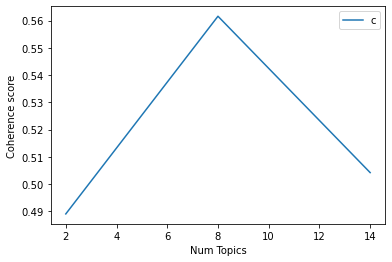

In [20]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Select the model and print the topics
optimal_model = ldamallet
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.038*"duque" + 0.024*"video" + 0.019*"amp" + 0.011*"happen" + '
  '0.010*"attack" + 0.010*"real" + 0.010*"stamp" + 0.009*"colombia" + '
  '0.009*"please_help" + 0.009*"world"'),
 (1,
  '0.034*"social" + 0.029*"joven" + 0.023*"pueblo" + 0.022*"criminal" + '
  '0.017*"matar" + 0.016*"estar" + 0.015*"dar" + 0.015*"gracia" + '
  '0.014*"civil" + 0.012*"asesinar"'),
 (2,
  '0.056*"gobierno" + 0.039*"paro" + 0.039*"nacional" + 0.034*"colombio" + '
  '0.018*"mejor" + 0.017*"acabar" + 0.016*"vivo" + 0.014*"dictadura" + '
  '0.013*"vivir" + 0.013*"corrupcion"'),
 (3,
  '0.045*"people" + 0.042*"police" + 0.037*"colombian" + 0.033*"protest" + '
  '0.028*"kill" + 0.021*"government" + 0.013*"protester" + 0.013*"violence" + '
  '0.013*"shoot" + 0.012*"day"'),
 (4,
  '0.039*"ir" + 0.039*"querer" + 0.031*"solo" + 0.029*"persona" + 0.025*"si" + '
  '0.024*"mas" + 0.019*"hablar" + 0.015*"situacion" + 0.014*"quedar" + '
  '0.013*"necesitar"'),
 (5,
  '0.042*"hacer" + 0.035*"vida" + 0.031*"todo" 

### Finding dominant topic in each sentence

In [22]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/huiwen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1250,"duque, video, amp, happen, attack, real, stamp...",hacer mayo cazar fantasma
1,1,4.0,0.1500,"ir, querer, solo, persona, si, mas, hablar, si...",despues esperar ancia ahora esperar despues se...
2,2,7.0,0.1737,"ver, poder, gente, ser, parte, politico, favor...",esperar llegar oido nuevo iniciar laboral part...
3,3,4.0,0.1584,"ir, querer, solo, persona, si, mas, hablar, si...",menos mes urkullu temer perder control dar pas...
4,4,1.0,0.1422,"social, joven, pueblo, criminal, matar, estar,...",edicion festival internacional puente hacia ce...
5,5,0.0,0.1250,"duque, video, amp, happen, attack, real, stamp...",cgt celebrar mayo hostigamiento sufrido empresa
6,6,2.0,0.1394,"gobierno, paro, nacional, colombio, mejor, aca...",cgt celebrar acto central primero mayo
7,7,7.0,0.1400,"ver, poder, gente, ser, parte, politico, favor...",conmemorar dia internacional trabajador ocasio...
8,8,0.0,0.1250,"duque, video, amp, happen, attack, real, stamp...",pasado puente san jose pasado semana santo abe...
9,9,5.0,0.1403,"hacer, vida, todo, estar, calle, apoyar, igual...",pascua resurreccion domingo posterior primero ...


In [50]:
# df_dominant_topic.to_csv('df_dominant_topic')

In [23]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3933,"duque, video, amp, happen, attack, real, stamp...",acabo de buscarlo noté que ya lo moderaste man...
1,1.0,0.3240,"social, joven, pueblo, criminal, matar, estar,...",carrasquilla exministro hacendarenunce5er ayer...
2,2.0,0.3237,"gobierno, paro, nacional, colombio, mejor, aca...",resumen automatico texto estrategia oculto com...
3,3.0,0.4397,"people, police, colombian, protest, kill, gove...",answer recent protest tax increase answer incr...
4,4.0,0.4308,"ir, querer, solo, persona, si, mas, hablar, si...",opinar igual desigualdad ver principalmente sa...
5,5.0,0.3081,"hacer, vida, todo, estar, calle, apoyar, igual...",gente bien seguir cuento reconciliacion cali i...
6,6.0,0.8012,"country, people, government, tax, time, good, ...",come point sacrifice need make crisis perfect ...
7,7.0,0.6344,"ver, poder, gente, ser, parte, politico, favor...",pais sufrir grave crisis economico social azot...


In [24]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"duque, video, amp, happen, attack, real, stamp...",6082.0,0.2745
1.0,4.0,"ir, querer, solo, persona, si, mas, hablar, si...",3144.0,0.1419
2.0,7.0,"ver, poder, gente, ser, parte, politico, favor...",2911.0,0.1314
3.0,4.0,"ir, querer, solo, persona, si, mas, hablar, si...",1911.0,0.0862
4.0,1.0,"social, joven, pueblo, criminal, matar, estar,...",2470.0,0.1115
5.0,0.0,"duque, video, amp, happen, attack, real, stamp...",2368.0,0.1069
6.0,2.0,"gobierno, paro, nacional, colombio, mejor, aca...",1216.0,0.0549
7.0,7.0,"ver, poder, gente, ser, parte, politico, favor...",2058.0,0.0929
8.0,0.0,"duque, video, amp, happen, attack, real, stamp...",NaN,NaN
9.0,5.0,"hacer, vida, todo, estar, calle, apoyar, igual...",NaN,NaN


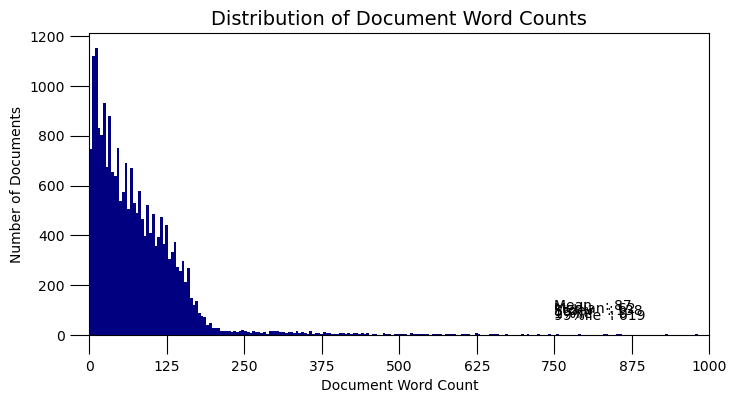

In [29]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(8,4), dpi=100)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=14)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=14))
plt.show()

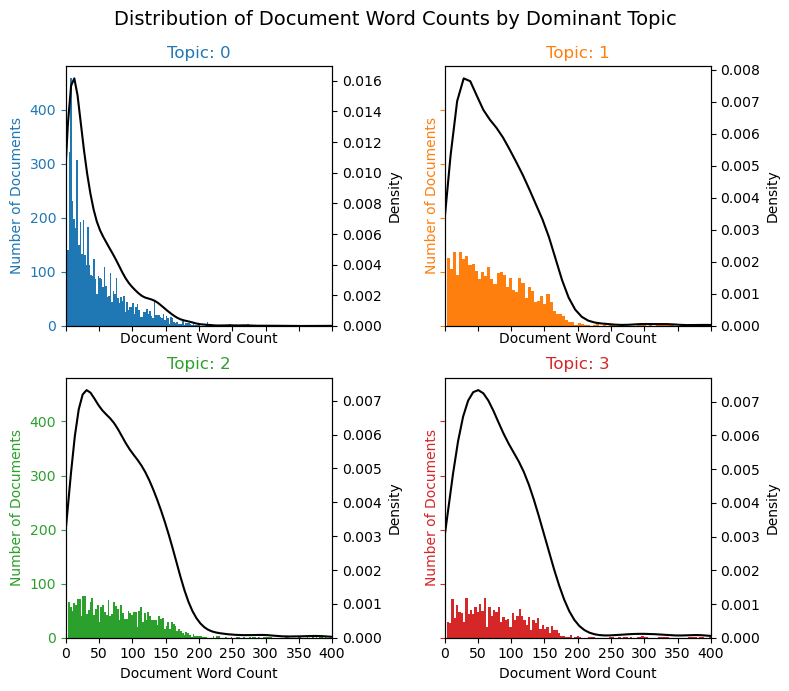

In [46]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(8,7), dpi=100, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 400, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 400), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=12, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,400,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=14)
plt.show()

IndexError: list index out of range

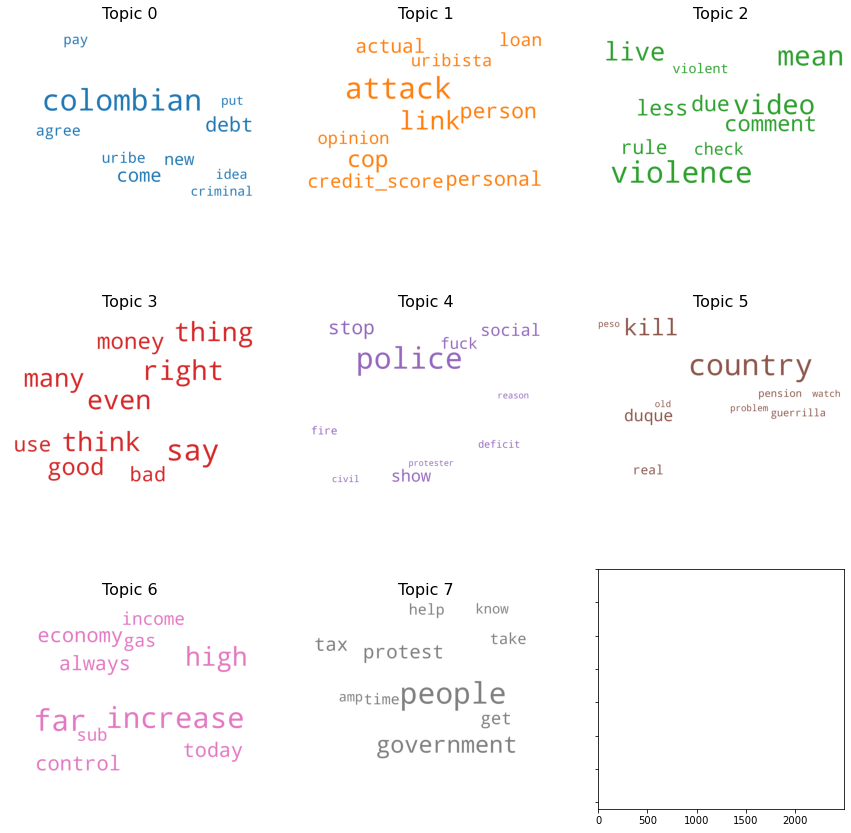

In [47]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [35]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)           

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

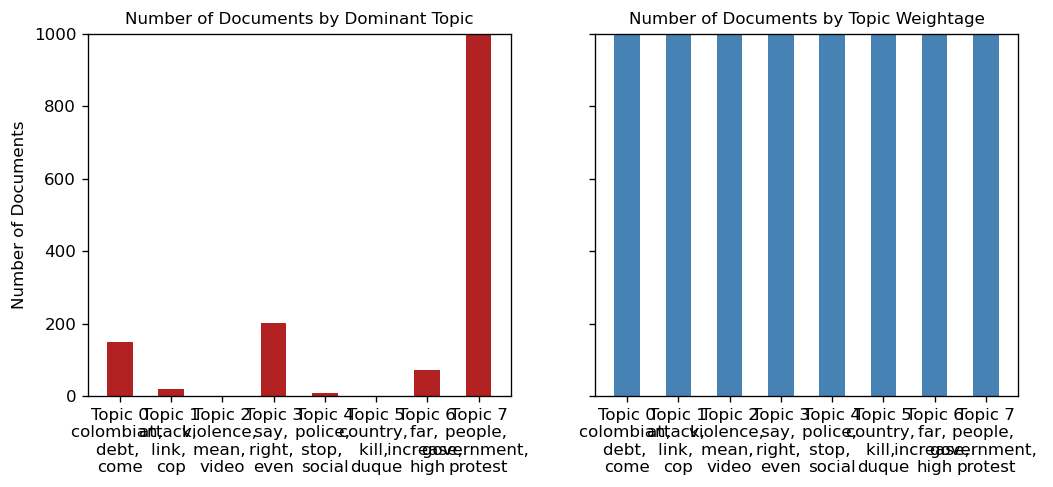

In [36]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=100, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()